In [1]:
from init import *
from utility import *
from repro import readfile

autotime loaded.


In [2]:
class Reprobus():
    def __init__(self, filename, nlev=60, nbcon=44, ncm=15):
        self.nlev = nlev
        p0, rascp = 1000.0, 2.0/7.0
        self.filename = filename
        self.date = pd.to_datetime(filename.split('_')[2], format='%Y%m%d%H')
        pj1, uj1, vj1, alt, tj1, qj1, hc = readfile(filename, nlev, nbcon, ncm)
        
        lats = xr.DataArray(np.arange(90, -91, -2), dims='Latitude', attrs={'long_name':'Latitude'})
        lons = xr.DataArray(np.arange(0, 360, 2), dims='Longitude', attrs={'long_name':'Longitude'})
        levs = np.arange(nlev)#[::-1]
        
        pj1 = xr.DataArray(pj1, dims=['Longitude', 'Latitude'], coords=[lons, lats], \
                   attrs={'long_name':'Pressure [hPa]'})

        uj1 = xr.DataArray(uj1, dims=['Longitude', 'Latitude', 'Level'], coords=[lons, lats, levs], \
                           attrs={'long_name':'uwind [m/s]'})

        vj1 = xr.DataArray(vj1, dims=['Longitude', 'Latitude', 'Level'], coords=[lons, lats, levs], \
                           attrs={'long_name':'vwind [m/s]'})

        tj1 = xr.DataArray(tj1, dims=['Longitude', 'Latitude', 'Level'], coords=[lons, lats, levs], \
                           attrs={'long_name':'Temperature [K]'})

        oz = xr.DataArray(hc[:, :, :, 4]/1e-6, dims=['Longitude', 'Latitude', 'Level'], coords=[lons, lats, levs], \
                           attrs={'long_name':'Ozone [ppmv]'})

        clo = xr.DataArray(hc[:, :, :, 10]/1e-9, dims=['Longitude', 'Latitude', 'Level'], coords=[lons, lats, levs], \
                           attrs={'long_name':'ClO [ppbv]'})

        hno3g = xr.DataArray(qj1[:, :, :, 42]/1e-9, dims=['Longitude', 'Latitude', 'Level'], coords=[lons, lats, levs], \
                           attrs={'long_name':'HNO$_3$ [ppbv]'})

        hno3 = xr.DataArray(qj1[:, :, :, 3]/1e-9, dims=['Longitude', 'Latitude', 'Level'], coords=[lons, lats, levs], \
                           attrs={'long_name':'HNO$_3$ [ppbv]'})

        n2o = xr.DataArray(qj1[:, :, :, 0]/1e-9, dims=['Longitude', 'Latitude', 'Level'], coords=[lons, lats, levs], \
                           attrs={'long_name':'N$_2$O [ppbv]'})

        alt = xr.DataArray(alt, dims=['Longitude', 'Latitude', 'Level'], coords=[lons, lats, levs], \
                           attrs={'long_name':'Altitude [km]'})
        
        aa, bb = self.get_coeffs()
        pmb = np.zeros(tj1.shape)
        for i in levs:
            pmb[:, :, i] = aa[i] + bb[i] * pj1 
            
        self.pressure = xr.DataArray(pmb, dims=['Longitude', 'Latitude', 'Level'], \
                           coords=[lons, lats, levs], \
                           attrs={'long_name':'Pressure [mb]'})

        self.theta = tj1 * ((p0/pmb)**rascp)
        
        self.surf_press = pj1
        self.uwind = uj1
        self.vwind = vj1
        self.altitude = alt
        self.temperature = tj1
        self.ozone = oz
        self.clo = clo
        self.hno3g = hno3g
        self.hno3 = hno3
        self.n2o = n2o       
        
    def get_coeffs(self):
        cfile = 'ecmwf_%s_levels.txt'%self.nlev
        df = pd.read_csv(cfile, sep='\s+', skiprows=[1])
        aa = 0.01 * df['a'].rolling(1).mean()[1:].values
        bb = df['b'].rolling(1).mean()[1:].values
        return aa, bb
    
    def interpolate_to_theta(self, ds, islev=np.arange(300, 900, 5)):
        islev = xr.DataArray(islev, coords = [islev], dims=['level'], \
                     attrs = {'units': 'K', 'long_name': 'Temperature'})
        isoz = xrvinterp(ds, self.theta, islev, 'Level', 'level')
        return isoz

time: 8.55 ms


In [3]:
bus = Reprobus('/home/pankaj/phd/code/model/model/reprobus/try1/MODEL_history_2019050112_001410')
isoz = bus.interpolate_to_theta(bus.ozone)
isoz

<xarray.DataArray (Longitude: 180, Latitude: 91, level: 120)>
array([[[0.13456677, 0.15924726, 0.18439097, ..., 4.57879752,
         4.58541022, 4.59202293],
        [0.0893074 , 0.1289259 , 0.16884401, ..., 4.81359206,
         4.8238846 , 4.83417713],
        [0.10842047, 0.14628009, 0.1841397 , ..., 4.7800783 ,
         4.79173421, 4.80339012],
        ...,
        [0.09632759, 0.11056253, 0.12175271, ..., 2.5694125 ,
         2.5690413 , 2.56867011],
        [0.09500845, 0.10907235, 0.1223533 , ..., 2.57079529,
         2.57367027, 2.57654525],
        [0.10411652, 0.11456631, 0.12563348, ..., 2.55685378,
         2.56102338, 2.56519299]],

       [[0.13606728, 0.15635179, 0.18170778, ..., 4.58010215,
         4.5860081 , 4.59191405],
        [0.09085402, 0.13035961, 0.17027538, ..., 4.81991992,
         4.83029938, 4.84067885],
        [0.10787689, 0.14587386, 0.18387084, ..., 4.78523674,
         4.79695755, 4.80867837],
        ...,
        [0.09412451, 0.10782121, 0.12124667, ..., 2.57243639,
         2.57196656, 2.57149673],
        [0.09432926, 0.1085518 , 0.12193566, ..., 2.57012038,
         2.5726489 , 2.57517742],
        [0.1042476 , 0.11458604, 0.12559303, ..., 2.55673726,
         2.56094625, 2.56515524]],

       [[0.13629837, 0.1531752 , 0.17912757, ..., 4.58098388,
         4.58611348, 4.59124309],
        [0.09245997, 0.13179352, 0.17168645, ..., 4.8265537 ,
         4.83696691, 4.84738013],
        [0.10860805, 0.1459374 , 0.18326675, ..., 4.79034915,
         4.80212239, 4.81389563],
        ...,
        [0.09239598, 0.10533133, 0.11992383, ..., 2.57480074,
         2.57425262, 2.57370449],
        [0.09368914, 0.10803879, 0.12147986, ..., 2.56948204,
         2.57173892, 2.57399579],
        [0.10434986, 0.11459133, 0.1255416 , ..., 2.5564986 ,
         2.56075501, 2.56501142]],

       ...,

       [[0.1513547 , 0.15984136, 0.18266865, ..., 4.57383555,
         4.58255637, 4.59127718],
        [0.08581047, 0.12493891, 0.16423196, ..., 4.79398589,
         4.8040598 , 4.81413372],
        [0.10871006, 0.14178201, 0.17498017, ..., 4.76411606,
         4.77547659, 4.78683713],
        ...,
        [0.09977023, 0.10973038, 0.11951396, ..., 2.55743567,
         2.55729217, 2.55714866],
        [0.097007  , 0.11093062, 0.12441639, ..., 2.56493144,
         2.5686277 , 2.57232395],
        [0.10407011, 0.11457519, 0.12563427, ..., 2.55643789,
         2.56061778, 2.56479767]],

       [[0.14763262, 0.15940904, 0.18220483, ..., 4.57506011,
         4.58311887, 4.59117764],
        [0.08660727, 0.12613329, 0.16582507, ..., 4.80069715,
         4.81082677, 4.82095639],
        [0.11002392, 0.14488669, 0.17974946, ..., 4.76965423,
         4.78111138, 4.79256852],
        ...,
        [0.09961003, 0.1106471 , 0.12046633, ..., 2.56207071,
         2.56183433, 2.56159795],
        [0.09636937, 0.11015772, 0.12335723, ..., 2.56730037,
         2.57075634, 2.57421232],
        [0.10404643, 0.11456586, 0.12564741, ..., 2.55661729,
         2.56077294, 2.56492858]],

       [[0.13941131, 0.16083823, 0.18455197, ..., 4.57695395,
         4.58427802, 4.59160209],
        [0.08791119, 0.12754296, 0.16739631, ..., 4.8071921 ,
         4.81740113, 4.82761015],
        [0.10930615, 0.14620987, 0.18311359, ..., 4.77495656,
         4.78651773, 4.7980789 ],
        ...,
        [0.09834687, 0.11123842, 0.12134192, ..., 2.56593583,
         2.56563579, 2.56533574],
        [0.09571775, 0.1095831 , 0.12271533, ..., 2.56949398,
         2.57268811, 2.57588224],
        [0.10404101, 0.11455766, 0.12565264, ..., 2.5568618 ,
         2.5609991 , 2.5651364 ]]])
Coordinates:
  * Latitude   (Latitude) int64 90 88 86 84 82 80 78 ... -80 -82 -84 -86 -88 -90
  * Longitude  (Longitude) int64 0 2 4 6 8 10 12 ... 346 348 350 352 354 356 358
  * level      (level) int64 300 305 310 315 320 325 ... 870 875 880 885 890 895

time: 6.93 s


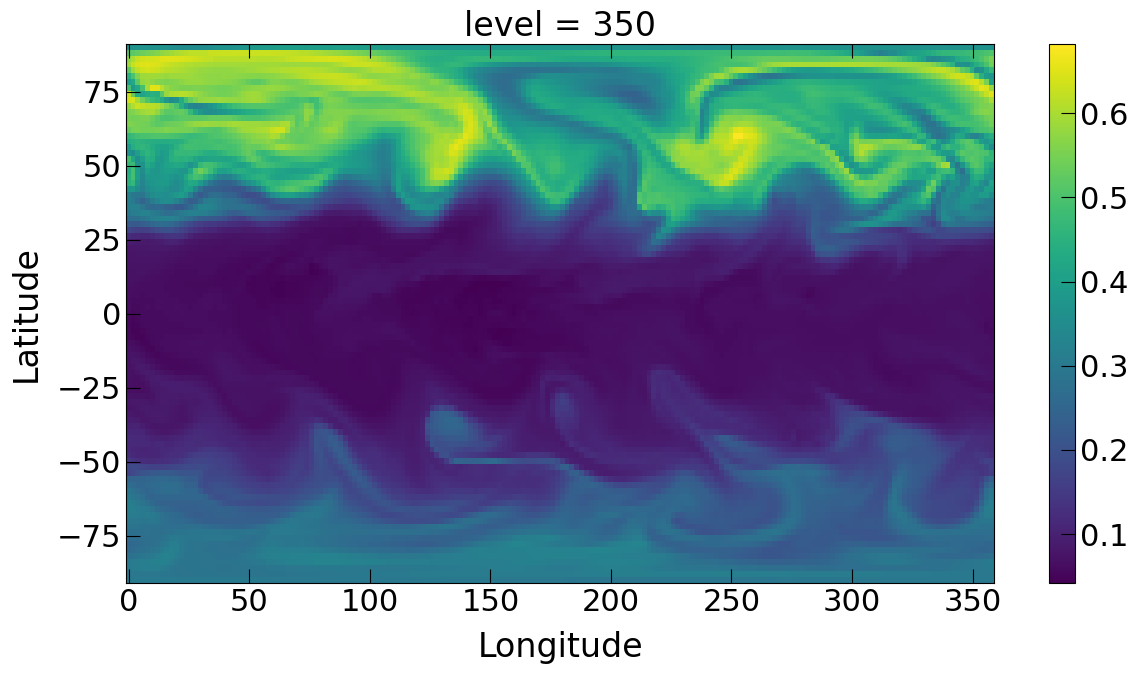

time: 644 ms


In [5]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
isoz[:, :, 10].T.plot(ax=ax)
plt.savefig('altitude_reprobus.png', bbox_inches='tight')
plt.show()